In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np


In [58]:
df = pd.read_csv(
    "../data/cleaned_data/atl311_2025_all_request_merged_with_geocodes.csv",
    parse_dates=["Opened", "Closed Date 1", "Closed Date 2", "closed"],
    low_memory=False
)


In [59]:
df["is_active"] = df["Status"].str.lower().eq("active")
df["is_resolved"] = df["Status"].str.lower().eq("resolved")

# SLA definition (example: 7 days = 168 hours)
SLA_HOURS = 168

df["sla_met"] = (
    df["is_resolved"] &
    (df["resolution_time_hours"] <= SLA_HOURS)
)

df["sla_violated"] = (
    df["is_resolved"] &
    (df["resolution_time_hours"] > SLA_HOURS)
)


In [60]:
df = df[
    (df["ok"] == True) &
    df["lat"].notna() &
    df["lng"].notna()
]
len(df)


119642

In [61]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lng"], df["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y


In [62]:
x_bins = pd.cut(gdf["x"], 75)
y_bins = pd.cut(gdf["y"], 75)


In [63]:
grid = (
    gdf
    .groupby([x_bins, y_bins])
    .agg(
        total_requests=("Number", "count"),
        active_requests=("is_active", "sum"),
        resolved_requests=("is_resolved", "sum"),
        sla_met_requests=("sla_met", "sum"),
        sla_violations=("sla_violated", "sum"),
    )
    .reset_index()
)


C:\Users\shrey\AppData\Local\Temp\ipykernel_5004\2984397693.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([x_bins, y_bins])


In [64]:
grid["norm_burden"] = (
    grid["total_requests"] / grid["total_requests"].max()
)


In [65]:
grid["backlog_pressure"] = (
    grid["active_requests"] /
    np.sqrt(grid["total_requests"])
)


In [66]:
grid["sla_violation_rate"] = np.where(
    grid["resolved_requests"] > 0,
    grid["sla_violations"] / grid["resolved_requests"],
    0
)


In [67]:
def minmax(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

grid["burden_score"] = minmax(grid["norm_burden"])
grid["backlog_score"] = minmax(grid["backlog_pressure"])
grid["sla_score"] = minmax(grid["sla_violation_rate"])


In [68]:
grid["service_stress_score"] = (
    0.4 * grid["burden_score"] +
    0.35 * grid["backlog_score"] +
    0.25 * grid["sla_score"]
)


In [69]:
grid["x_mid"] = grid.iloc[:, 0].apply(lambda b: b.mid)
grid["y_mid"] = grid.iloc[:, 1].apply(lambda b: b.mid)

grid_gdf = gpd.GeoDataFrame(
    grid,
    geometry=gpd.points_from_xy(grid["x_mid"], grid["y_mid"]),
    crs="EPSG:3857"
)


In [71]:
plot_gdf = grid_gdf[grid_gdf["total_requests"] >= 1].copy()


In [73]:
plot_gdf["marker_size"] = (
    np.log1p(plot_gdf["total_requests"]) * 20
)


KeyboardInterrupt: 

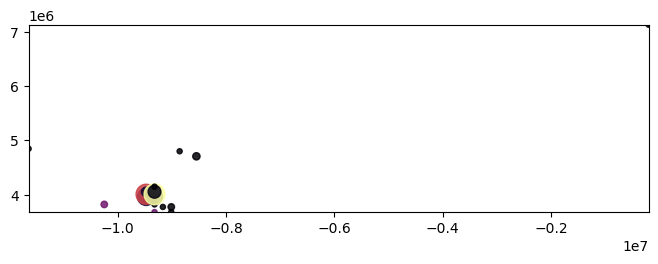

In [74]:
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(8, 8))

# Color normalization
norm = colors.Normalize(
    vmin=plot_gdf["service_stress_score"].min(),
    vmax=plot_gdf["service_stress_score"].max()
)

plot_gdf.plot(
    ax=ax,
    markersize=plot_gdf["marker_size"],
    color=cm.inferno(norm(plot_gdf["service_stress_score"])),
    alpha=0.85
)

# Clamp extent (CRITICAL)
xmin, ymin, xmax, ymax = plot_gdf.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Basemap (ONLY ONCE)
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)

# Colorbar (manual, fast)
sm = cm.ScalarMappable(norm=norm, cmap="inferno")
sm._A = []
plt.colorbar(sm, ax=ax, shrink=0.6, label="Service Stress Score")

ax.set_title("Atlanta 311 – Service Stress Score (Grid-Level)")
ax.set_aspect("equal")
ax.axis("off")
plt.show()


In [75]:
plot_gdf.to_file("service_stress_grid.geojson", driver="GeoJSON")


In [82]:
import numpy as np

plot_gdf = grid_gdf[grid_gdf["total_requests"] >= 0].copy()

x = plot_gdf.geometry.x.values
y = plot_gdf.geometry.y.values

score = plot_gdf["service_stress_score"].values
size = np.log1p(plot_gdf["total_requests"].values) * 20


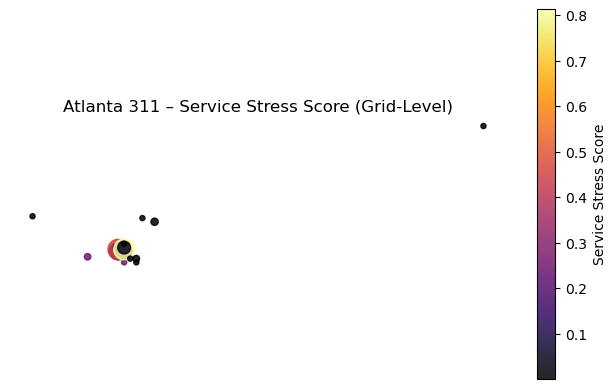

In [83]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

sc = ax.scatter(
    x,
    y,
    c=score,
    s=size,
    cmap="inferno",
    alpha=0.85
)

plt.colorbar(sc, ax=ax, shrink=0.6, label="Service Stress Score")

ax.set_title("Atlanta 311 – Service Stress Score (Grid-Level)")
ax.set_aspect("equal")
ax.axis("off")

plt.show()


In [84]:
plot_gdf["service_stress_score"].describe()


count    19.000000
mean      0.120145
std       0.209715
min       0.000005
25%       0.000005
50%       0.008013
75%       0.166158
max       0.812896
Name: service_stress_score, dtype: float64

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# -----------------------------
# 1. Read cleaned geocoded CSV
# -----------------------------
df = pd.read_csv(
    "../data/cleaned_data/atl311_2025_all_request_merged_with_geocodes.csv",
    parse_dates=["Opened", "Closed Date 1", "Closed Date 2", "closed"],
    low_memory=False
)

# -----------------------------
# 2. Keep only valid geocodes
# -----------------------------

df = df[
    df["ok"]
    .astype(str)
    .str.strip()
    .str.lower()
    .isin(["true", "1", "yes"])
]

df = df[
    df["lat"].between(33.60, 33.90) &
    df["lng"].between(-84.55, -84.25)
].copy()


# -----------------------------
# 3. Create GeoDataFrame (WGS84)
# -----------------------------

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lng"], df["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8, 8))

gdf.plot(
    ax=ax,
    markersize=1,
    alpha=0.25
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12 
)

ax.set_title("Atlanta 311 All Requests")
ax.axis("off")
plt.show()

